In [108]:
import yfinance as yf
from src import meanReversionTest
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

importlib.reload(meanReversionTest)

<module 'src.meanReversionTest' from 'c:\\Users\\jnche\\Desktop\\Personal Projects\\algotrade\\project1\\src\\meanReversionTest.py'>

Download the specified price data using yfinance.

In [109]:
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start='2015-01-01', end='2024-01-01', auto_adjust=False)
print(data['Adj Close'].head())
adjCloseData = data['Adj Close']

[*********************100%***********************]  2 of 2 completed

Ticker           AAPL       MSFT
Date                            
2015-01-02  24.237556  39.858448
2015-01-05  23.554745  39.491928
2015-01-06  23.556961  38.912300
2015-01-07  23.887281  39.406673
2015-01-08  24.805086  40.565952


Using simple visualization techniques, see if the selected tickers might possibly be cointegrable.

In the price series plot, we are looking for the tickers to "mirror" each other.

In the scatter plot, we are looking for a relatively linear relationship.

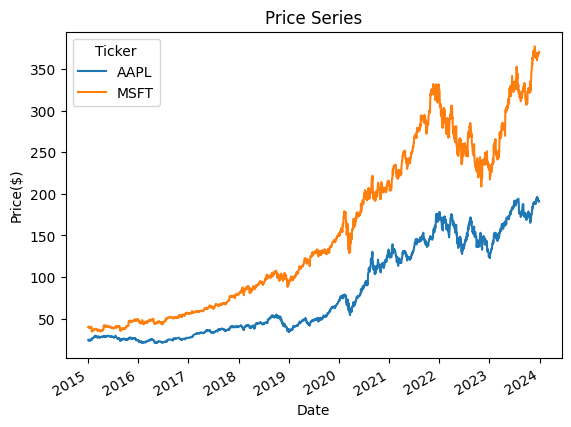

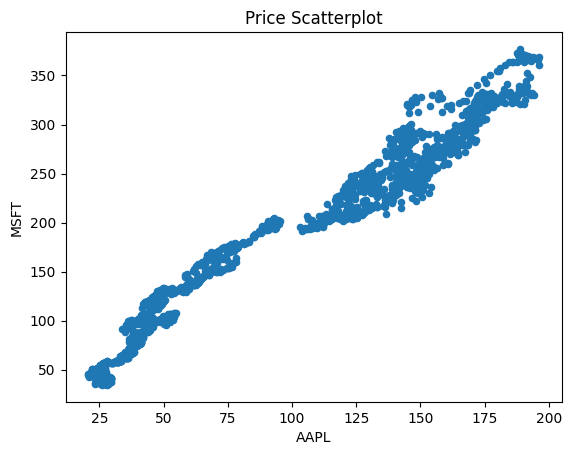

In [110]:
meanReversionTest.plotPriceSeries(adjCloseData)
meanReversionTest.plotScatterSeries(adjCloseData)

Now, we run the CADF test.

First, we fit a linear model to the scatter plot of the two price series.
* This gives us the residuals, along with some other information.
* The residuals are the distance between the predictions of our linear model (using the price series that we set as the independent variable), and the actual price (the other price series that we set as the dependent variable)
* Here, we just choose the price series in the first column of adjCloseData to be the independent variable.

We can plot the residuals to see if, visually, they look like they might be mean reverting.

Finally, we run ADF on the residuals to test if the residuals actually are mean reverting.

c:\Users\jnche\Desktop\Personal Projects\algotrade\project1\src\meanReversionTest.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


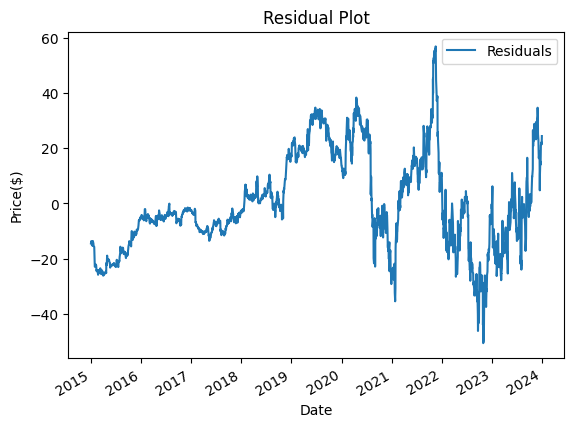

Test statistic: -2.7469831984295476
p value: 0.06625496501980666


In [111]:
adjCloseData, beta, intercept = meanReversionTest.fitLinearModel(adjCloseData)
meanReversionTest.plotResiduals(adjCloseData)
testStatistic, pValue, criticalValues = meanReversionTest.doCadf(adjCloseData)

If we determine, based on the test statistic and the p value, that the two price series are cointegrable, we can now specify a linear mean reverting trading strategy and backtest.

First, we calculate the z-score of the spreads/residuals.

In [112]:
spread = adjCloseData['Residuals']
spread = spread.to_numpy()
zscore = (spread - spread.mean()) / spread.std()
print(zscore[:5])

[-0.83377112 -0.78597295 -0.8195678  -0.8244364  -0.85030495]


Then, we backtest.

In [113]:
def calculatePnL(typ: str, entrySpread: float, exitSpread: float) -> float:
    '''
    Calculates the profit and loss based on the current position
    '''
    if typ == 'short':
        return entrySpread - exitSpread # here, we sell high, buy low
    elif typ == 'long':
        return exitSpread - entrySpread # here, we buy low, sell high
    else:
        print(f'ERROR: unexpected type of {typ}.')
        return 0

allPositions = []
currentPositions = []
cumulativePnL = pd.DataFrame(columns=['Time', 'Cumulative PnL'])
cumulativePnL.loc[0] = [0, 0]

for t in range(len(zscore)):
    if zscore[t] > 2:
        # short
        currentPositions.append({'type': 'short', 'enterTime': t, 'enterSpread': spread[t]})
    elif zscore[t] < -2:
        # long
        currentPositions.append({'type': 'long', 'enterTime': t, 'enterSpread': spread[t]})
    elif abs(zscore[t]) < 0.5:
        # exit positions, but only if we actually hold any
        if len(currentPositions) == 0:
            continue
        print(f'exit, t = {t}')
        tCumulativePnL = 0
        for pos in currentPositions:
            pos['exitTime'] = t
            pos['exitSpread'] = spread[t]
            pnl = calculatePnL(pos['type'], pos['enterSpread'], pos['exitSpread'])
            pos['PnL'] = pnl
            tCumulativePnL += pnl
            allPositions.append(pos)
        currentPositions = []
        newRow = pd.DataFrame([{'Time': t, 'Cumulative PnL': cumulativePnL.iloc[-1]['Cumulative PnL'] + tCumulativePnL}])
        cumulativePnL = pd.concat([cumulativePnL, newRow], ignore_index = True)

print(cumulativePnL)

exit, t = 1404
exit, t = 1532
exit, t = 1750
exit, t = 2002
   Time  Cumulative PnL
0     0        0.000000
1  1404      197.798511
2  1532      226.044457
3  1750     1196.374029
4  2002     1871.693652


Evaluate performance using:
* Equity curve (cumulative PnL)
* Sharpe ratio
* Max Drawdown
* Number of trades / win rate

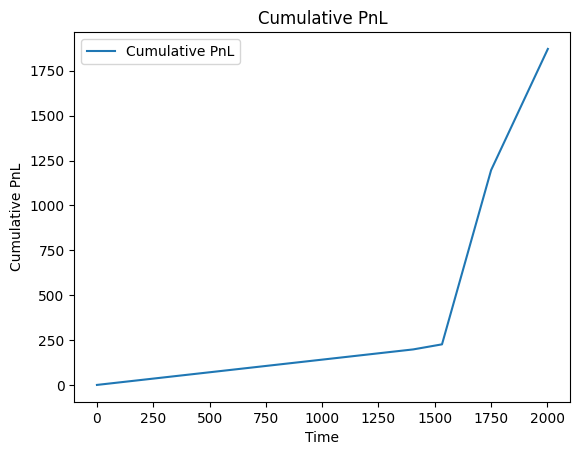

In [114]:
fig = cumulativePnL.plot(x = 'Time', y = 'Cumulative PnL', title="Cumulative PnL")
fig.set_ylabel("Cumulative PnL")
plt.show()